<a href="https://colab.research.google.com/github/aplneto/gerador-de-frases-desmotivacionais/blob/main/if866_-_criatividade_computacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install transformers==4.18.0 --quiet

In [ ]:
from transformers import GPT2Tokenizer, GPT2Model, pipeline

In [ ]:
GPT2_MODEL_NAME = 'pierreguillou/gpt2-small-portuguese'
GPT2_MODEL_URL = 'https://huggingface.co/pierreguillou/gpt2-small-portuguese'
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(
    GPT2_MODEL_NAME,
    bos_token='<|startoftext|>',
    eos_token='<|endoftext|>',
    pad_token='<|pad|>',
    sep_token='<|sep|>'
)
gpt2_model = GPT2Model.from_pretrained(GPT2_MODEL_NAME, return_dict=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at pierreguillou/gpt2-small-portuguese were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from transformers import set_seed

In [ ]:
generator = pipeline('text-generation', model=gpt2_model.name_or_path)
set_seed(42)
generator(
    "Quem era Jim Henson? Jim Henson era um",
    max_length=30,
    num_return_sequences=5
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Quem era Jim Henson? Jim Henson era um "patrão", mas seu passado e personalidade eram claramente mais forte que seu irmão, embora ele'},
 {'generated_text': 'Quem era Jim Henson? Jim Henson era um membro da família DuPont (que era de ascendência norte-americana) e Jim Jr. ('},
 {'generated_text': 'Quem era Jim Henson? Jim Henson era um engenheiro de máquinas e eletricidade. Jim Henson começou seus estudos para estudar eletromagnetismo. \n\n'},
 {'generated_text': 'Quem era Jim Henson? Jim Henson era um bom amigo de Frank Lloyd Wright e seu editor de "The New Yorker". "Jim H'},
 {'generated_text': 'Quem era Jim Henson? Jim Henson era um funcionário do governo nos EUA, e o Sr. Henson era um dos donos da empresa.'}]

In [ ]:
set_seed(4)
generator('Nada é tão ruim que não', num_return_sequences = 5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Nada é tão ruim que não podemos dar isso e nem nos ajudar a melhorar nossas vidas como um todo, quando se tratamos da gente, de crianças, de adolescentes e de famílias".\nJosé Manuel Soares, Presidente da Fundação Fernando Collor, (São'},
 {'generated_text': 'Nada é tão ruim que não é mais de tudo para eles, mas sim uma tarefa e um projeto. "Um dia você conhece alguém que está a ponto de alguém que vai querer algo e que por isso você está ansioso para algo que o outro não'},
 {'generated_text': 'Nada é tão ruim que não consegue se entender em que circunstâncias. "\n\nEm um dia que começa bem como tudo, ele está sempre com emoções que o levou a acreditar que ele está no caminho a chegar a ser realmente grande demais. Mas ele'},
 {'generated_text': 'Nada é tão ruim que não seria um dos piores momentos da vida. Nós ficamos em uma fazenda mexicana e todos os outros seres faltaram... É um grande desastre", afirma Regina para o jornal americano "The New York Times".\nA n

In [ ]:
!pip install spacy --quiet

In [ ]:
# !python -m spacy download pt_core_news_sm --quiet
# !python -m spacy download pt_core_news_md --quiet
# !python -m spacy download pt_core_news_lg --quiet

In [ ]:
!pip install odfpy --quiet

In [ ]:
import pandas

In [ ]:
dataframe = pandas.read_excel('frasesDesmotivacionais.ods', engine='odf')

In [ ]:
dataframe.reset_index(drop=True, inplace=True)
dataframe.drop(labels='ID', inplace=True, axis=1)
dataframe.rename(columns = {'Frases': 'completion'}, inplace=True)
dataframe.head()

,completion
0,Nenhum obstáculo é grande para quem desiste.
1,Nada é tão horrível que não possa piorar muito!
2,É só uma fase logo vai piorar.
3,Você não pode mudar o seu passado. Mas pode es...
4,Sem lutas não há derrotas.


In [ ]:
import torch
import spacy
import random
from torch.utils.data import Dataset

In [ ]:
maxl = 50

In [ ]:
SPECIAL_TOKENS = gpt2_tokenizer.special_tokens_map

In [ ]:
class SentenceDataset(Dataset):
  def __init__(self, sentence_list, tokenizer, gpt2_type, max_length=maxl):
    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []
    self.nlp = spacy.load("pt_core_news_lg")
    self.sentences = sentence_list

    for inputs, masks in self.get_inputs_and_masks():
      self.input_ids.append(inputs)
      self.attn_masks.append(masks)

  def __len__(self):
    return len(self.input_ids)
  
  def get_inputs_and_masks(self):
    for sentence in self.sentences:
      input = (
          SPECIAL_TOKENS['bos_token'] +
          ','.join(self.get_sentence_keywords(sentence)) +
          SPECIAL_TOKENS['sep_token'] +
          sentence +
          SPECIAL_TOKENS['eos_token']
      )
      encoding_dict = self.tokenizer(
          input,
          truncation=True,
          max_length=maxl,
          padding='max_length'
      )
      inputs = torch.tensor(encoding_dict['input_ids'])
      masks = torch.tensor(encoding_dict['attention_mask'])
      yield inputs, masks
  
  def reset_dataset(self):
    for i, inputs, masks in enumerate(self.get_inputs_and_masks()):
      self.input_ids[i] = inputs
      self.attn_masks[i] = maks
  
  def __getitem__(self, i):
    return self.input_ids[i], self.attn_masks[i]
  
  def get_sentence_keywords(self, text):
    doc = self.nlp(text)
    stopwords = self.nlp.Defaults.stop_words
    keywords = [token.lemma_ for token in doc if token.lemma_ not in stopwords]
    for word in keywords:
      if word in ',.?!:;-/@':
        keywords.remove(word)
    random.shuffle(keywords)
    return keywords

In [ ]:
dataset = SentenceDataset(
    dataframe['completion'], gpt2_tokenizer, gpt2_model.name_or_path
)
dataset[0]

(tensor([50257,  1201,  4645,    12, 34955,  7211,    12,    78, 32664, 50258,
         44897, 26234,   372,   867,   341,  2033, 41736,    14,     0, 50259,
         50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259,
         50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259,
         50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]))

In [ ]:
from torch.utils.data import DataLoader, RandomSampler

In [ ]:
batchsize = 10

dataloader = DataLoader(
    dataset,
    sampler = RandomSampler(dataset),
    batch_size = batchsize
)

In [ ]:
from transformers import AutoModelWithLMHead, GPT2Config

In [ ]:
configuration = GPT2Config.from_pretrained(
    GPT2_MODEL_NAME, output_hidden_states=False
)
model = AutoModelWithLMHead.from_pretrained(
    GPT2_MODEL_NAME, config=configuration
)

C:\Users\aplne\anaconda3\envs\cuda-torch\lib\site-packages\transformers\models\auto\modeling_auto.py:907: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [ ]:
model.resize_token_embeddings(len(gpt2_tokenizer))

Embedding(50260, 768)

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  model.cuda()
else:
  device = torch.device('cpu')
  model.cpu()

In [ ]:
import numpy

In [ ]:
seed_val = 42
random.seed(seed_val)
numpy.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

In [ ]:
epochs = 100
warmup_steps = 1e2
sample_every = 10

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, eps=1e-8)

In [ ]:
from transformers import get_linear_schedule_with_warmup

In [ ]:
total_steps = len(dataset) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps = warmup_steps, num_training_steps = total_steps
)

In [ ]:
model = model.to(device)

In [ ]:
gpt2_tokenizer.decode(model.generate()[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


' Olivais, em <|startoftext|> bi, no <|startoftext|> bi, no <|startoftext|> bi, no <|startoftext|> bi, no <|startoftext|>'

In [ ]:
train_loss_hist = []
for epoch_i in range(epochs):
  total_train_loss = 0
  model.train()
  print(f'Epoch: {epoch_i+1}/{epochs}')
  for step, batch in enumerate(dataloader):
    b_input_ids = batch[0].to(device)
    b_labels = batch[0].to(device)
    b_masks = batch[1].to(device)

    model.zero_grad()
    outputs = model(
        b_input_ids, labels=b_labels,
        attention_mask = b_masks,
        token_type_ids=None
    )

    loss = outputs[0]

    batch_loss = loss.item()
    total_train_loss += batch_loss

    if (((step+1) % sample_every) == 0):
      model.eval()
      prompt = SPECIAL_TOKENS['bos_token'] + SPECIAL_TOKENS['sep_token']
      p = torch.tensor(gpt2_tokenizer.encode(prompt)).unsqueeze(0)
      p = p.to(device)
      sample_outputs = model.generate(
          p,
          do_sample=True,
          max_length = maxl,
          num_return_sequences=1
      )
      sample_seq = sample_outputs[0]
      out_seq = gpt2_tokenizer.decode(sample_seq, skip_special_tokens=True)
      print(f'Example output: [{out_seq}]')

      model.train()
    
    loss.backward()
    optimizer.step()
    scheduler.step()
  
  avg_train_loss = total_train_loss / len(dataloader)
  print(f'Average Training Loss: {avg_train_loss}.')
  train_loss_hist.append(avg_train_loss)
  if len(train_loss_hist) > 5:
    last = train_loss_hist[-1:-6:-1]
    diff = [0] * len(last)
    for i in range(len(last)-1):
      diff[i] = last[i] - last[i + 1]
    max_diff = max(diff)
    if max_diff <- 1e-3:
      print(f'Stop condition loss <= {max_diff} reached! Stopping...')
      break

Epoch: 1/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: []
Average Training Loss: 6.201900911331177.
Epoch: 2/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: []
Average Training Loss: 3.9514854192733764.
Epoch: 3/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: []
Average Training Loss: 3.5463915348052977.
Epoch: 4/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: ["

"É a maior festa, mais divertida.]
Average Training Loss: 3.1362552404403687.
Epoch: 5/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [gaçar a cara se se você for bem. A única coisa melhor é que você não tenha dúvidas - e nunca vai se tornar uma estrela.
O Tantra é um romance escrito por]
Average Training Loss: 2.8342395305633543.
Epoch: 6/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [, Mistério, o, o, o, o o o o o o]
Average Training Loss: 2.4820915699005126.
Epoch: 7/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [, Abrigo, Bacofo,,A BêA BêA BêBoiBoA BêNão ama ninguém! colspan="3" style="background: #FBEC]
Average Training Loss: 2.145303463935852.
Epoch: 8/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [,caVocê também é um idiota, você sabe que sempre espera que vai ganhar., um solitário, não é muito inteligente, mas ele é do coração.]
Average Training Loss: 1.8500720500946044.
Epoch: 9/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [AboOber,ninguém é tão bom que não tem mais.]
Average Training Loss: 1.6383500695228577.
Epoch: 10/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Não se esforçar. nunca foi uma mulher bonita. sempre foi uma beleza perfeita. sempre vai fazer o que quiser.]
Average Training Loss: 1.456993329524994.
Epoch: 11/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Você tem que fazer as pessoas acreditar e tentar. O seu fracasso não te deixa pior para o seu futuro.]
Average Training Loss: 1.3024450421333313.
Epoch: 12/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Não é fácil ir embora. Esta é a única pista que você consegue chegar. Essa é a primeira vez que sua vida é realmente um pesadelo.]
Average Training Loss: 1.1566892921924592.
Epoch: 13/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Não pare de se interessar por ninguém, pare de chorar mesmo!

Tentar o seu caminho com Tudo]
Average Training Loss: 1.0306907296180725.
Epoch: 14/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você quiser, se você morrer, se você morrer sem dar umSe você quiser, chorar sem chorar e olhando no espelho se você morrer sem tentar isso.
Quando eu era muito pequena, era]
Average Training Loss: 0.9122086822986603.
Epoch: 15/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Não procure por dinheiro, apenas o ideal é que goste de você. Coruja de ouro. Mulher que não precisa de muito]
Average Training Loss: 0.8114401519298553.
Epoch: 16/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Você é bonito e você é insensível. O seu primeiro]
Average Training Loss: 0.7426798403263092.
Epoch: 17/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Um castigo para você não é bom, é para você que merece um castigo de longo prazo. A vida é feita de obstáculos. A vida é feita de obstáculos.]
Average Training Loss: 0.6532348155975342.
Epoch: 18/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. compôs sua versão perfeita de Alberto não foi fácil. compôs sua versão perfeita de Alberto
A maior]
Average Training Loss: 0.6262912750244141.
Epoch: 19/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [É por isso que você é feio e não vai piorar muito. A não foi fácil, mas]
Average Training Loss: 0.5611521542072296.
Epoch: 20/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você é bom não dará certo.Nunca consiga dizer que não vai dar certo.Nunca consiga dizer que não vai dar certo.]
Average Training Loss: 0.5103677362203598.
Epoch: 21/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Nunca procure por dinheiro sem espera, nunca mais vai trabalhar sem espera e nunca mais dará quaisquer outras oportunidades. Nunca foi para o Rio ninguém pensou no seu potencial. Um sonho já era feita]
Average Training Loss: 0.4702070504426956.
Epoch: 22/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. não estaria lendo isso. não estaria lendo isso. não estaria lendo isso.]
Average Training Loss: 0.4243940144777298.
Epoch: 23/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Só dará errado se você tentar. Ela não te fala de você e sim de você. lembrou de você mesmo, mas achou que era ruim. lembrou de você]
Average Training Loss: 0.3832604855298996.
Epoch: 24/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse fraco você estaria muito melhor lendo isso e te olhando pra você. E não te achou fraco. E foi muito ruim.]
Average Training Loss: 0.3450438678264618.
Epoch: 25/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. Mais uma vez, mais uma frase. Mais uma vez, mais uma frase. Mais uma vez]
Average Training Loss: 0.3068677395582199.
Epoch: 26/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. Se você fosse bom não estaria lendo isso. Se você fosse bom não estaria lendo isso.]
Average Training Loss: 0.2907674551010132.
Epoch: 27/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Não pare faça até dar errado. Abre, não tem tempo para dar errado. Esta é a frase que sempre vai dando errado.]
Average Training Loss: 0.27224206924438477.
Epoch: 28/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Você está triste, mas não pode mudar o seu fracasso. compôs um dos melhores momentos do seu passado. compôs um dos piores momentos do seu passado.]
Average Training Loss: 0.23927571773529052.
Epoch: 29/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. Sem você não conseguia fazer tudo nem comece. A não era nem uma páreo para o seu]
Average Training Loss: 0.23847173154354095.
Epoch: 30/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. não estaria lendo isso. não estaria lendo isso.]
Average Training Loss: 0.2308502599596977.
Epoch: 31/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom no passado não estaria lendo isso e não irá se adaptar. A personagem de A personagem de E no seu caso,]
Average Training Loss: 0.20855211168527604.
Epoch: 32/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. não foi bom, mas também não foi ruim. não foi ruim, mas também não foi incrível.]
Average Training Loss: 0.198589426279068.
Epoch: 33/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso.Nenhum grande astro já tinha sido fotografado por ele. Se você fosse bom não estaria lendo isso.]
Average Training Loss: 0.19337324500083924.
Epoch: 34/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Nunca foi azar sempre foi incompetência. não foi fácil. não foi fácil. Você não foi fácil, mas foi fácil. Você foi]
Average Training Loss: 0.18722666054964066.
Epoch: 35/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Você é bonito, mas não é bonito. não são suas criações que são bonitas, pois são criações ruins. lembrou de você, mas era para pedir dinheiro emprestado.]
Average Training Loss: 0.1782981902360916.
Epoch: 36/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Só dará errado se você tentar. A melhor parte do caminho é quando percebemos que é impossível realizá-lo. A melhor parte do caminho é quando percebemos que é]
Average Training Loss: 0.17449527531862258.
Epoch: 37/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. não estaria lendo isso. não estaria lendo isso. não estaria lendo isso. não estaria lendo isso.]
Average Training Loss: 0.16866144984960557.
Epoch: 38/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. lembrou de você, mas era para pedir dinheiro emprestado. lembrou de você, mas era para pedir dinheiro emprestado.]
Average Training Loss: 0.17195143699645996.
Epoch: 39/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. não estaria lendo isso. não estaria lendo isso. não estaria lendo isso.]
Average Training Loss: 0.17319050580263137.
Epoch: 40/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. não estaria lendo isso. não estaria lendo isso. não estaria lendo isso.]
Average Training Loss: 0.160005521774292.
Epoch: 41/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Você não pode conseguir tudo o que quiser não pode fazer tudo o que quiser não pode fazer tudo o que quiser Você não pode fazer tudo o que quiser Você não]
Average Training Loss: 0.16713034436106683.
Epoch: 42/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. não sabendo que era impossível foi lá e soube. E não foi fácil.]
Average Training Loss: 0.1623230293393135.
Epoch: 43/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Você é fraco e inútil. não sabendo que era impossível foi lá e soube.
Seu primeiro álbum de estúdio foi lançado em 1987,]
Average Training Loss: 0.15416625887155533.
Epoch: 44/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. lembrou de você mesmo, mas era para pedir dinheiro emprestado. lembrou de você mesmo,]
Average Training Loss: 0.15532123669981956.
Epoch: 45/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. não sabendo que era impossível foi lá e soube. Sober, logo foi ruim.]
Average Training Loss: 0.14458406195044518.
Epoch: 46/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Nunca foi azar sempre foi incompetência. O fracasso nunca foi grande, sempre foi incompetência. Mas foi lá que você foi, e ela]
Average Training Loss: 0.1570403754711151.
Epoch: 47/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Você não é bonito e muito menos especial. A melhor parte do seu ‘desistir’. A melhor parte do ‘abra’,]
Average Training Loss: 0.15514184162020683.
Epoch: 48/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Algumas pessoas te incentivam para rir do seu fracasso, outros incentivam para rir do seu fracasso. inventou o primeiro papel que parecesse perfeita foi feita de papel.]
Average Training Loss: 0.14684196412563325.
Epoch: 49/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. Escreveu, desenhou, e publicou uma serie de histórias curtas. foi ilustrador da personagem "OEsqueça do Mal", de]
Average Training Loss: 0.1493782475590706.
Epoch: 50/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. compôs o primeiro A música que você sempre pensou que era impossível foi feita de alegria. compôs]
Average Training Loss: 0.15163008123636246.
Epoch: 51/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. Nunca foi bom muito para ninguém e sempre foi ruim. Never foi bom para ninguém. Nunca]
Average Training Loss: 0.15361745953559874.
Epoch: 52/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Você não é incrível e muito menos especial. não se sinta envergonhado por sua falta de atenção. não se sinta envergonhado por sua falta de atenção.]
Average Training Loss: 0.14229879826307296.
Epoch: 53/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. não estaria lendo isso. não estaria lendo isso.]
Average Training Loss: 0.14315104484558105.
Epoch: 54/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso.Nunca pensou em seguir seu coração e a sua intuição. Nunca pensou em seguir seu coração e]
Average Training Loss: 0.14149743989109992.
Epoch: 55/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. compôs o seu próprio hino. compôs sua própria canção. compôs seu próprio hino.]
Average Training Loss: 0.14532629474997522.
Epoch: 56/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso.Nunca foi azar sempre foi muito ruim.Nunca foi azar sempre foi muito ruim.Nunca foi]
Average Training Loss: 0.14701199904084206.
Epoch: 57/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. não estaria lendo isso. não estaria lendo isso. não estaria lendo isso.]
Average Training Loss: 0.14225581288337708.
Epoch: 58/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. lembrou de você mesmo quando lembrou de você. Sensei no seu fracasso e soube do seu fracasso]
Average Training Loss: 0.14111757427453994.
Epoch: 59/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. Escreveu vários livros, todos reconhecidos pela crítica. Alguns deles foram traduzidos para o espanhol. Um de seus outros títulos é brasileiro traduzido para o francês]
Average Training Loss: 0.14041908979415893.
Epoch: 60/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. lembrou de você mesmo, mas agora falta a motivação para continuar lendo. lembrou de você mesmo não foi bomOPE e agora falta]
Average Training Loss: 0.14008536487817763.
Epoch: 61/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. não estaria lendo isso. Não estaria lendo isso.]
Average Training Loss: 0.13709936812520027.
Epoch: 62/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. Nunca foi bom para ninguém. Nunca foi bom para ninguém. Never foi ruim para ninguém]
Average Training Loss: 0.14304991513490678.
Epoch: 63/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Você não pode conseguir tudo o que quiser não conte seus planos a ninguém. Nada faz você desistir do seu coração. A única]
Average Training Loss: 0.15109153389930724.
Epoch: 64/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. Mais um dia que passa e tua insignificância prevalece. Mais um dia que passa e tua insignificância]
Average Training Loss: 0.1364132285118103.
Epoch: 65/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. não estaria lendo isso. O seu fracasso não estaria dando certo. Você]
Average Training Loss: 0.13979457467794418.
Epoch: 66/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. não sabendo que era impossível foi lá e soube. S S S A sombra só te]
Average Training Loss: 0.136842293292284.
Epoch: 67/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria pronto para estragar isso. não foi fácil, mas fracassei novamente. lembrou de você, mas era para pedir dinheiro emprestado.]
Average Training Loss: 0.12821184173226358.
Epoch: 68/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. Mais um obstáculo que você já tem. E mais um obstáculo que você já tem.]
Average Training Loss: 0.1419300302863121.
Epoch: 69/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Você não pode fazer isso! não foi fácil, mas fracassei novamente. excelentes amigas só te incentivam para rir do seu fracasso. excelentes amigas só]
Average Training Loss: 0.13844866901636124.
Epoch: 70/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. O ideal é simples, mas extremamente errada. Sozinha poderiam te humilhar sem que ninguém saiba,]
Average Training Loss: 0.1347833126783371.
Epoch: 71/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [As pessoas só te incentivam para rir do seu fracasso. A sua vida não pode ficar pior. A sua vida não pode ficar pior.]
Average Training Loss: 0.13234477788209914.
Epoch: 72/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. Ainda não foi fácil, mas agora parece que piorou.]
Average Training Loss: 0.13474856838583946.
Epoch: 73/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. compôs a sua história. compôs a sua história. compôs a quem você achou mais fraco.]
Average Training Loss: 0.1272970162332058.
Epoch: 74/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. não estaria lendo isso. não estaria lendo isso. não estaria lendo isso. não]
Average Training Loss: 0.1274445451796055.
Epoch: 75/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. compôs o primeiro single do seu álbum, "Unprecisar, donSe você fosse bom não estaria lendo isso. compôs]
Average Training Loss: 0.1287342555820942.
Epoch: 76/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. não estaria lendo isso. não estaria lendo isso. não estaria lendo isso]
Average Training Loss: 0.13168180361390114.
Epoch: 77/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Você não pode conseguir tudo o que quiserNunca foi azar sempre foi incompetência.Nunca foi azar sempre foi incompetência.Nunca foi azar sempre foi incom]
Average Training Loss: 0.13607831597328185.
Epoch: 78/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. Mas o seu fracasso não irá se alterar. E o seu fracasso não irá se alterar.]
Average Training Loss: 0.12679281160235406.
Epoch: 79/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. não foi fácil, mas fracassei novamente. novamente fracassei novamente. novamente fracassei novamente]
Average Training Loss: 0.132776989787817.
Epoch: 80/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. O fracasso não dura para sempre. A sua vida é um eterno nocaute no primeiro round.]
Average Training Loss: 0.13242363184690475.
Epoch: 81/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. não sabendo que era impossível foi lá e soube. Se você fosse bom não estaria lendo isso.]
Average Training Loss: 0.13745702058076859.
Epoch: 82/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Você não é bonito, apenas nasceu com beleza natural. lembrou de você mesmo, mas era para pedir dinheiro emprestado. lembrou de você mesmo, mas era para pedir dinheiro]
Average Training Loss: 0.13460846841335297.
Epoch: 83/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. Nunca foi melhor que ela também foi obrigada. Nunca foi melhor que ela também foi obrigada. Nunca foi]
Average Training Loss: 0.1298007383942604.
Epoch: 84/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Toma,pagarToma aqui o seu boleto pra você ir pagar de trouxa. lembrou de você mesmo, mas era para pedir dinheiro emprestado. lembrou de você]
Average Training Loss: 0.13160354718565942.
Epoch: 85/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. lembrou de você mesmo, mas era para pedir dinheiro emprestado. lembrou lembrou de você mesmo, mas era para pedir]
Average Training Loss: 0.13245131745934485.
Epoch: 86/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Você não é disso você é feio. não foi fácil, mas fracassei novamente. A fracassei novamente.]
Average Training Loss: 0.12774414718151092.
Epoch: 87/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. 
Fonte base de remédios. fonte de remédios. fonte de remédios.]
Average Training Loss: 0.13305687606334687.
Epoch: 88/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. lembrou de você mesmo, mas foi azar. lembrou de você mesmo, mas foi azar.]
Average Training Loss: 0.12898928672075272.
Epoch: 89/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. Escreveu vários livros, um de filosóficos e a maior parte de sua vida foi gasta na escrita de livros. compôs vários]
Average Training Loss: 0.12406751960515976.
Epoch: 90/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. A sombra só te segue porque é obrigada.]
Average Training Loss: 0.1349985420703888.
Epoch: 91/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Não pare faça até dar errado. O fracasso te espera. O fracasso te espera.]
Average Training Loss: 0.11871371045708656.
Epoch: 92/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [ o,derrota,vencer,siVencer a si próprio é a maior das derrotas. derrotas são a principal das derrotas. derrotas são a principal das derrotas.]
Average Training Loss: 0.13112416565418245.
Epoch: 93/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. Escreveu muitos poemas, mas mais de um romance. também escreveu: Um dia, eu morrer.]
Average Training Loss: 0.12752530425786973.
Epoch: 94/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. lembrou de você, mas era para pedir dinheiro emprestado. lembrou de você, mas era para pedir dinheiro emprestado.]
Average Training Loss: 0.12736572325229645.
Epoch: 95/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. lembrou de você, mas era para pedir dinheiro emprestado. lembrou de você, mas era para pedir dinheiro emprestado.]
Average Training Loss: 0.13003842905163765.
Epoch: 96/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. Nunca foi bom para ninguém. Nunca foi bom para ninguém. Never foi]
Average Training Loss: 0.12263429388403893.
Epoch: 97/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. compôs uma sinfonia. compôs uma sinfonia. compôs uma sinfonia.]
Average Training Loss: 0.1257796823978424.
Epoch: 98/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. Nunca foi bom, mas foi ruim. Never foi ruim, mas foi pior. Never foi]
Average Training Loss: 0.1237793117761612.
Epoch: 99/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. lembrou de você, mas era para pedir dinheiro emprestado. lembrou de você, mas era para pedir dinheiro emprestado.]
Average Training Loss: 0.1284512273967266.
Epoch: 100/100


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: [Se você fosse bom não estaria lendo isso. lembrou de você mesmo, mas era para pedir dinheiro emprestado. lembrou de você mesmo, mas era para pedir dinheiro emprestado]
Average Training Loss: 0.12750575542449952.


In [ ]:
model.eval()
# Generate from keyword
k = dataset.get_sentence_keywords(dataframe.sample().values[0,0])
prompt = SPECIAL_TOKENS['bos_token'] + ','.join(k) + SPECIAL_TOKENS['sep_token']

generated = torch.tensor(gpt2_tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
    generated,
    do_sample=True,
    top_k=50,
    max_length = 50,
    temperature=0.9,
    repetition_penalty=5.0,
    num_return_sequences=3,
    early_stopping=True
)

start = len(','.join(k))
for i, sample_output in enumerate(sample_outputs):
  text = gpt2_tokenizer.decode(sample_output, skip_special_tokens=True)
  print("{}: {}\n\n".format(i,text[start:]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Trabalho com o que você ama e nunca mais vai amar nada. disse para não dizer algo de ruim a ninguém ou muito menos ao seu vizinho musical. Começar é


1: Trabalho com o que você ama e nunca mais vai amar nada. amante do seu dia de namorados é tarde demais para se envergonhar novamente com a sua noite anterior.. A melhor


2: Trabalho com o que você ama e nunca mais vai amar nada. nunca foi bom no espelho mas agora é ruim”. A melhor parte do seu fracasso total não pode sair




In [ ]:
# Generate from empty prompt
prompt = SPECIAL_TOKENS['bos_token'] + SPECIAL_TOKENS['sep_token']

generated = torch.tensor(gpt2_tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
    generated,
    do_sample=True,
    top_k=30,
    max_length = 50,
    top_p=0.7,
    temperature=0.9,
    repetition_penalty=2.0,
    num_return_sequences=3,
    early_stopping=True
)

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, gpt2_tokenizer.decode(
      sample_output, skip_special_tokens=True
  )))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Se você fosse bom não estaria lendo isso. lembrou de você mesmo, mas era para pedir dinheiro emprestado. lembrou de você mesmo, mas foi pra ficar ruim novamente


1: Se você fosse bom não estaria lendo isso. lembrou de você, mas era para pedir dinheiro emprestado. lembrou de você, mas foi pra pedindo algo muito mais especial


2: Se você fosse bom não estaria lendo isso. E o seu fracasso te espera. A sua derrota é certa. A




In [ ]:
# Generate from empty prompt with no sampling
prompt = SPECIAL_TOKENS['bos_token'] + SPECIAL_TOKENS['sep_token']

generated = torch.tensor(gpt2_tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
    generated,
    do_sample=False,
    top_k=30,
    max_length = 50,
    top_p=0.7,
    temperature=0.9,
    repetition_penalty=2.0,
    num_return_sequences=1,
    early_stopping=True
)

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, gpt2_tokenizer.decode(
      sample_output, skip_special_tokens=True
  )))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Se você fosse bom não estaria lendo isso. lembrou de você mesmo, mas era para pedir dinheiro emprestado. lembrou de você mesmo, mas foi pra ficar ruim




In [ ]:
from matplotlib import pyplot

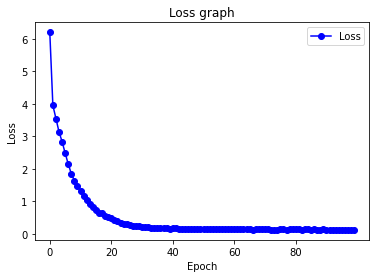

In [ ]:
%matplotlib inline

pyplot.plot(train_loss_hist, 'b-o', label='Loss')
pyplot.title('Loss graph')
pyplot.xlabel("Epoch")
pyplot.ylabel("Loss")
pyplot.legend()
pyplot.xticks(list(range(0, 100, 20)))

pyplot.rcParams["figure.figsize"] = (20,20)
pyplot.rcParams['figure.dpi'] = 100

pyplot.show()


In [ ]:
gpt2_tokenizer.save_pretrained('tokenizer')

('tokenizer\\tokenizer_config.json',
 'tokenizer\\special_tokens_map.json',
 'tokenizer\\vocab.json',
 'tokenizer\\merges.txt',
 'tokenizer\\added_tokens.json')

In [ ]:
!pip install session-info

  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8053 sha256=482bfc5915a9498dec8231703b27fd5fc2f1712927ae9c24746c0acee7a33627
  Stored in directory: c:\users\aplne\appdata\local\pip\cache\wheels\d4\fc\2e\00ca60bac7954b84907efd41baa9b4853500eaeec4228410c6
Successfully built session-info


In [ ]:
import session_info
session_info.show()